<font color="#006400" face="sans-serif" size="7">
<b>Erika Shrestha</b>
</font>
<BR>
<font color="#006400" face="sans-serif" size="4.5">
<b>London Met ID: 23048598</b>
</font>

---



<b>FindCite is a text classification model that automatically classify citations in research papers according to their purpose.</b>

In [1]:
#INSTALL necessary librabries that are not by-default stored in golab
#!pip install transformers
#!pip install sentencepiece
#!pip install datasets torch

---
---

# **TEMPORARY DATA LOAD**
This notebook is designed to be fully reproducible in Google Colab.
Please ensure the setup cells (dataset download and folder creation) are run sequentially before executing the rest of the notebook.

---
---

In [2]:
#CREATE an empty folder in colab temporary files
!mkdir -p data

In [3]:
#CONNECT the data files which contains train, test and validation
!wget https://ai2-s2-research.s3-us-west-2.amazonaws.com/scicite/scicite.tar.gz

--2026-01-12 17:26:02--  https://ai2-s2-research.s3-us-west-2.amazonaws.com/scicite/scicite.tar.gz
Resolving ai2-s2-research.s3-us-west-2.amazonaws.com (ai2-s2-research.s3-us-west-2.amazonaws.com)... 52.92.145.226, 3.5.84.107, 52.92.137.218, ...
Connecting to ai2-s2-research.s3-us-west-2.amazonaws.com (ai2-s2-research.s3-us-west-2.amazonaws.com)|52.92.145.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23189911 (22M) [application/x-tar]
Saving to: ‘scicite.tar.gz.2’

scicite.tar.gz.2    100%[===================>]  22.12M  36.8MB/s    in 0.6s    

2026-01-12 17:26:03 (36.8 MB/s) - ‘scicite.tar.gz.2’ saved [23189911/23189911]



In [4]:
#EXTRACT the connected taz file
!tar -xvzf scicite.tar.gz

scicite/
scicite/train.jsonl
scicite/scaffolds/
scicite/test.jsonl
scicite/dev.jsonl
scicite/scaffolds/cite-worthiness-scaffold-train.jsonl
scicite/scaffolds/sections-scaffold-train.jsonl


In [5]:
#MOVE the required json files into the created data folder
!mv scicite/train.jsonl scicite/dev.jsonl scicite/test.jsonl data/

In [6]:
#IMPORT all the necessary libraries used in the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import torch
import tf_keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [7]:
#IMPORT training data from data Folder
train_df = pd.read_json('data/train.jsonl', lines=True)
#head() shows only 5 documents by default
train_df.head()

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN


In [8]:
#IMPORT testing data from data Folder
test_df = pd.read_json('data/test.jsonl', lines=True)
#head() shows only 5 documents by default
test_df.head()

,source,citeEnd,sectionName,citeStart,string,label,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label_confidence
0,acronym,31.0,,28.0,"Chapel, as well as X10 [2], UPC [3] , CoArray ...",background,2c6797dab4c118cb73197f65ba39dacc99ac743d,95c37bc99982d33873fd141ee00857160fd717a0,True,2c6797dab4c118cb73197f65ba39dacc99ac743d>95c37...,2c6797dab4c118cb73197f65ba39dacc99ac743d>95c37...,6,NaN,NaN
1,explicit,166.0,Discussion,156.0,"In addition, the result of the present study s...",result,fa7145adc9f8cfb8af7a189d9040c13c84ced094,20e23b4f76761d246a7c3b00b80e139e2008f77d,False,fa7145adc9f8cfb8af7a189d9040c13c84ced094>20e23...,fa7145adc9f8cfb8af7a189d9040c13c84ced094>20e23...,0,supportive,NaN
2,explicit,145.0,Discussion,137.0,Several instruments that more specifically add...,background,98a8d8c0c5dae246720d4f339b88e8a9f44e3002,bd222c7ec83dadefba513738290b3624f6dd6b21,True,98a8d8c0c5dae246720d4f339b88e8a9f44e3002>bd222...,98a8d8c0c5dae246720d4f339b88e8a9f44e3002>bd222...,1,NaN,NaN
3,explicit,158.0,Methods,137.0,Organotypic hippocampal slice cultures\nInterf...,method,aeb178ef1910a61152cd74209c28641199c82855,754c04953c261072fa367f4104e3deff082d9484,False,aeb178ef1910a61152cd74209c28641199c82855>754c0...,aeb178ef1910a61152cd74209c28641199c82855>754c0...,1,NaN,1.0
4,explicit,186.0,RESULTS,178.0,Activated PBMC are the basis of the standard P...,background,e4d2591ac3bb65e2ec59f092884a7b15b8018592,f0fb468a54fe8021bc7986a1618222c4fcd16df4,False,e4d2591ac3bb65e2ec59f092884a7b15b8018592>f0fb4...,e4d2591ac3bb65e2ec59f092884a7b15b8018592>f0fb4...,6,NaN,NaN


In [9]:
#IMPORT validation data from data Folder
val_df = pd.read_json('data/dev.jsonl', lines=True)
#head() shows only 5 documents by default
val_df.head()

,source,citeEnd,sectionName,citeStart,string,label,label2,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label_confidence,label2_confidence
0,explicit,68.0,Discussion,64.0,These results are in contrast with the finding...,result,supportive,8f1fbe460a901d994e9b81d69f77bfbe32719f4c,5e413c7872f5df231bf4a4f694504384560e98ca,False,8f1fbe460a901d994e9b81d69f77bfbe32719f4c>5e413...,8f1fbe460a901d994e9b81d69f77bfbe32719f4c>5e413...,0,NaN,NaN
1,explicit,241.0,Discussion,222.0,…nest burrows in close proximity of one anothe...,background,NaN,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,10,0.7337,NaN
2,explicit,94.0,. 6 Discussion,71.0,This is clearly in contrast to the results of ...,result,supportive,226f798d30e5523c5b9deafb826ddb04d47c11dc,None,False,226f798d30e5523c5b9deafb826ddb04d47c11dc>None,226f798d30e5523c5b9deafb826ddb04d47c11dc>None_0,0,NaN,NaN
3,explicit,170.0,,148.0,"…in a subset of alcoholics (Chen et al., 2004;...",background,NaN,59dba7cd80edcce831d20b35f9eb597bba290154,273996fbf99465211eb8306abe8c56c5835f332e,False,59dba7cd80edcce831d20b35f9eb597bba290154>27399...,59dba7cd80edcce831d20b35f9eb597bba290154>27399...,0,1.0000,NaN
4,explicit,89.0,DISCUSSION,85.0,This result is consistent with the conclusions...,result,not_supportive,0640f6e098a9d241cd680473e8705357ae101e04,e33da0584b8db37816d510fd9ba7c1216858fd5f,False,0640f6e098a9d241cd680473e8705357ae101e04>e33da...,0640f6e098a9d241cd680473e8705357ae101e04>e33da...,0,NaN,NaN


**The original Scicite dataset provides separate train, development, and test splits. For understanding the characteristics of the datasets, the train and development sets were concatenated to form a larger labeled dataset while test sets were separated for model prediction due to absence of label_confidence.**

In [10]:
#CONCATINATE train and validation sets
explore_df = pd.concat([train_df, val_df])
explore_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,explicit,99.0,Discussion,71.0,Our results are consistent with those of a pre...,result,NaN,d9ef5d1cb543d0f1330908b36f7106f23cbad404,ae7c65d4d7710bf5f36309faea886648f9a51d4a,False,d9ef5d1cb543d0f1330908b36f7106f23cbad404>ae7c6...,d9ef5d1cb543d0f1330908b36f7106f23cbad404>ae7c6...,0,not_supportive,NaN
912,explicit,136.0,1. Introduction,129.0,Some of these peptides act as neurotoxins on t...,background,1.0,d937bc4d0722d5b45366b3c4dfde4732224bc048,9200a75534f44836ca7651c9d63d11b884947fa6,True,d937bc4d0722d5b45366b3c4dfde4732224bc048>9200a...,d937bc4d0722d5b45366b3c4dfde4732224bc048>9200a...,4,NaN,NaN
913,explicit,150.0,4. Discussion,144.0,"Therefore, despite an apparent higher number o...",background,1.0,3f50975c58d861e4fbd3b4fd065f0658b1aa1e10,d16a1d95e6947da69797bb0cb59148057174e35a,True,3f50975c58d861e4fbd3b4fd065f0658b1aa1e10>d16a1...,3f50975c58d861e4fbd3b4fd065f0658b1aa1e10>d16a1...,0,NaN,NaN
914,explicit,28.0,INTRODUCTION,13.0,According to Xu et al (2011) the factors that ...,method,NaN,d776ade6bb4898c032b971d2cec145976408e838,22e3889f93c19c15b746c1339ce9d7439ccb632e,False,d776ade6bb4898c032b971d2cec145976408e838>22e38...,d776ade6bb4898c032b971d2cec145976408e838>22e38...,0,NaN,NaN


----
----

# **Data Quality Check**

1.   Missing Values Check
2.   Column Consistency
3.   Duplication Check
4.   Label Distribution
5.   Text Length Distribution




---
---

#####**1. Missing Values Check**



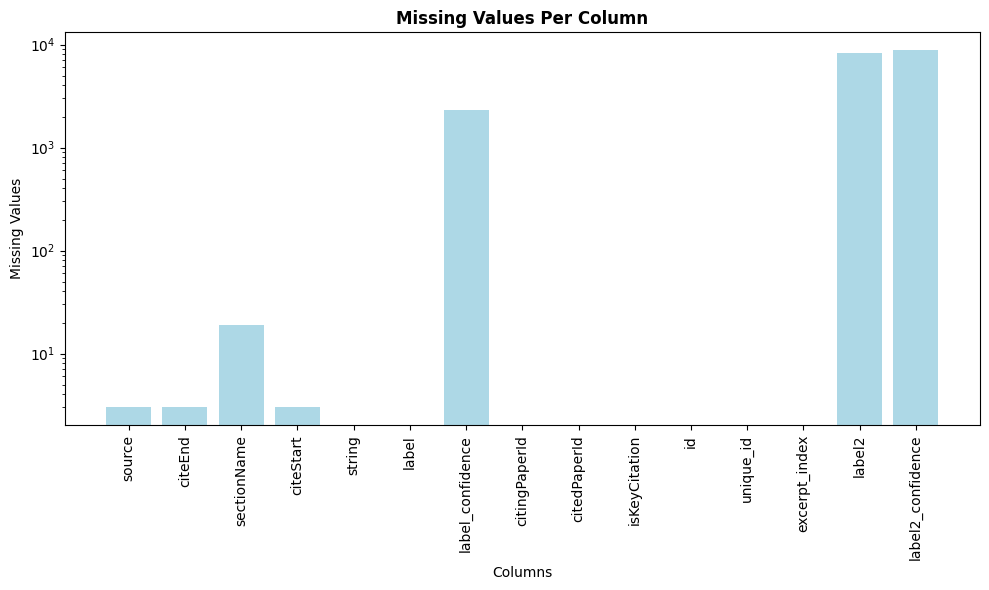

In [11]:
#checking the missing values of all the columns in the findcite_df
#logarithm scaling is used for y-axis to visualize columns with large gap in missing values
missing_counts = explore_df.isnull().sum()
plt.figure(figsize=(10,6))
plt.bar(missing_counts.index, missing_counts.values, color='#ADD8E6')
plt.yscale('log')
plt.title('Missing Values Per Column', fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel('Missing Values')
plt.xlabel('Columns')
plt.tight_layout()

In [12]:
#check whether there is presence of high missing values (case = missing_values > 50%)
total_rows = len(explore_df)
missing_percent_per_columns = ((missing_counts / total_rows) * 100).round(1)
missing_percent_per_columns

,0
source,0.0
citeEnd,0.0
sectionName,0.2
citeStart,0.0
string,0.0
label,0.0
label_confidence,25.5
citingPaperId,0.0
citedPaperId,0.0
isKeyCitation,0.0


#####**2. Column Consistency**

In [13]:
#checking columns for each dataframes
print(train_df.columns)
print(val_df.columns)
print(test_df.columns)

Index(['source', 'citeEnd', 'sectionName', 'citeStart', 'string', 'label',
       'label_confidence', 'citingPaperId', 'citedPaperId', 'isKeyCitation',
       'id', 'unique_id', 'excerpt_index', 'label2', 'label2_confidence'],
      dtype='object')
Index(['source', 'citeEnd', 'sectionName', 'citeStart', 'string', 'label',
       'label2', 'citingPaperId', 'citedPaperId', 'isKeyCitation', 'id',
       'unique_id', 'excerpt_index', 'label_confidence', 'label2_confidence'],
      dtype='object')
Index(['source', 'citeEnd', 'sectionName', 'citeStart', 'string', 'label',
       'citingPaperId', 'citedPaperId', 'isKeyCitation', 'id', 'unique_id',
       'excerpt_index', 'label2', 'label_confidence'],
      dtype='object')


According to the comparison between different data sets, we can see there is column inconsistency in test_df where **label_confidence** column is missing.

In [14]:
#checking data types for each dataframes
print(f"\033[1mTrain sets data types:\033[0m\n{train_df.dtypes}\n")
print(f"\033[1mValidation sets data types:\033[0m\n{val_df.dtypes}\n")
print(f"\033[1mTest sets data types:\033[0m\n{test_df.dtypes}\n")

Train sets data types:
source                object
citeEnd              float64
sectionName           object
citeStart            float64
string                object
label                 object
label_confidence     float64
citingPaperId         object
citedPaperId          object
isKeyCitation           bool
id                    object
unique_id             object
excerpt_index          int64
label2                object
label2_confidence    float64
dtype: object

Validation sets data types:
source                object
citeEnd              float64
sectionName           object
citeStart            float64
string                object
label                 object
label2                object
citingPaperId         object
citedPaperId          object
isKeyCitation           bool
id                    object
unique_id             object
excerpt_index          int64
label_confidence     float64
label2_confidence    float64
dtype: object

Test sets data types:
source               object

#####**3. Duplication Check**

In [15]:
#shows all the duplicate rows in the dataframe through keep=false
duplicates = explore_df[explore_df.duplicated(keep=False)]
print(duplicates.to_string())

     source  citeEnd sectionName  citeStart                                                                                                                                                                                                                                                                                    string   label  label_confidence                             citingPaperId                              citedPaperId  isKeyCitation                                                                                 id                                                                            unique_id  excerpt_index          label2  label2_confidence
4378   None      NaN  DISCUSSION        NaN  PFC patients and controls did not differ with respect to the amount of time spent making the first move on each tower, a finding consistent with previous studies (Andres & Van der Linden, 2001; Goel & Grafman, 1995; Jacobs & Anderson, 2002; Owen et al., 1990; Rushe et al., 1999).  resu

The **4378** and **503** rows were found to have same entries for every columns.

#####**4. Label Distribution**

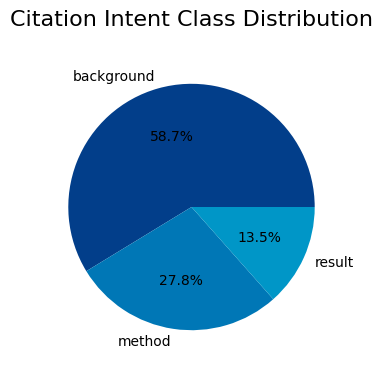

In [16]:
#calculates total occurrence for each classes to check class imbalance
class_counts = explore_df['label'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['#023e8a','#0077b6','#0096c7'])
plt.title('Citation Intent Class Distribution', fontsize=16, pad=20)
plt.show()

Upon calculation results, we see that the classes are distributed unevenly in label columns indicating class imbalance where **background** label has **58.7%** dominance, followed by **method** with **27.8%** and **result** with just **13.5%** which may bias the model toward the majority class (i.e. Background).

#####**5. Text Length Distribution**

In [17]:
#finds the text length in string column for each row
text_lengths = explore_df['string'].str.len()
#groups the extracted text length by label and calculates the average through mean()
avg_length = text_lengths.groupby(explore_df['label']).mean()

In [18]:
avg_length.round(1)

,string
label,
background,217.8
method,216.6
result,241.1


This check is done to ensure that differences in text length between classes do not unfairly influence the model performance. This ensures that the model should focus on semantic meaning rather than length.

---
---

# **Feature Selection**

---
---

In [19]:
#PERFORM Feature Selection for training sets
selected_train_df = train_df[['string','label']]
#head() shows only 5 documents by default
selected_train_df.head()

,string,label
0,"However, how frataxin interacts with the Fe-S ...",background
1,"In the study by Hickey et al. (2012), spikes w...",background
2,"The drug also reduces catecholamine secretion,...",background
3,By clustering with lowly aggressive close kin ...,background
4,Ophthalmic symptoms are rare manifestations of...,background


In [20]:
#PERFORM Feature Selection for testing sets
selected_test_df = test_df[['string','label']]
#head() shows only 5 documents by default
selected_test_df.head()

,string,label
0,"Chapel, as well as X10 [2], UPC [3] , CoArray ...",background
1,"In addition, the result of the present study s...",result
2,Several instruments that more specifically add...,background
3,Organotypic hippocampal slice cultures\nInterf...,method
4,Activated PBMC are the basis of the standard P...,background


In [21]:
#PERFORM Feature Selection for validation sets
selected_val_df = val_df[['string','label']]
#head() shows only 5 documents by default
selected_val_df.head()

,string,label
0,These results are in contrast with the finding...,result
1,…nest burrows in close proximity of one anothe...,background
2,This is clearly in contrast to the results of ...,result
3,"…in a subset of alcoholics (Chen et al., 2004;...",background
4,This result is consistent with the conclusions...,result


In [22]:
findcite_df = pd.concat([selected_train_df, selected_test_df, selected_val_df])
findcite_df

,string,label
0,"However, how frataxin interacts with the Fe-S ...",background
1,"In the study by Hickey et al. (2012), spikes w...",background
2,"The drug also reduces catecholamine secretion,...",background
3,By clustering with lowly aggressive close kin ...,background
4,Ophthalmic symptoms are rare manifestations of...,background
...,...,...
911,Our results are consistent with those of a pre...,result
912,Some of these peptides act as neurotoxins on t...,background
913,"Therefore, despite an apparent higher number o...",background
914,According to Xu et al (2011) the factors that ...,method


---
---

# **Text Preprocessing**

1.   Tokenization
2.   Text Removal (lower casing, punctuation removal, characters removal, space parsing removal, stopwords removal)
3.   Lemmatization
4.   Vectorization




---
---

In [23]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
#PREPARE stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [25]:
#CREATES method to perform text preprocessing
def preprocess_text(text):

  #INTRODUCES empty lists for every preprocessing steps
  lower_tokens = []
  clean_tokens = []
  filtered_tokens = []
  lemmatized_tokens = []

  #FIRST tokenize the text
  tokens = word_tokenize(text)

  #CONVERT tokens into lower casing
  for word in tokens:
    lower_tokens.append(word.lower())

  #CONVERTS lower tokens into stopwords removed tokens
  for word in lower_tokens:
    #REMOVE everything except letters
    cleaned = re.sub(r'[^a-zA-Z]', '', word)
    if cleaned != '':
        clean_tokens.append(cleaned)

  #CONVERTS lower tokens into stopwords removed tokens
  for word in clean_tokens:
    if word not in stop_words:
      filtered_tokens.append(word)

  #FILTERS base words from cleaned tokens
  for t in filtered_tokens:
    lemmatized_tokens.append(lemmatizer.lemmatize(t))

  #JOIN preprocessed tokens back to string
  return ' '.join(lemmatized_tokens)

In [26]:
findcite_df['cleaned_text'] = findcite_df['string'].apply(preprocess_text)

In [27]:
findcite_df

,string,label,cleaned_text
0,"However, how frataxin interacts with the Fe-S ...",background,however frataxin interacts fe cluster biosynth...
1,"In the study by Hickey et al. (2012), spikes w...",background,study hickey et al spike sampled field point p...
2,"The drug also reduces catecholamine secretion,...",background,drug also reduces catecholamine secretion ther...
3,By clustering with lowly aggressive close kin ...,background,clustering lowly aggressive close kin king b v...
4,Ophthalmic symptoms are rare manifestations of...,background,ophthalmic symptom rare manifestation intracra...
...,...,...,...
911,Our results are consistent with those of a pre...,result,result consistent previous study conducted mul...
912,Some of these peptides act as neurotoxins on t...,background,peptide act neurotoxin glutamate receptor cent...
913,"Therefore, despite an apparent higher number o...",background,therefore despite apparent higher number mean ...
914,According to Xu et al (2011) the factors that ...,method,according xu et al factor contribute bad quali...


In [28]:
 #DEFINE X (Features) and y (Target)
X = findcite_df['cleaned_text']
y = findcite_df['label']

In [29]:
#SPLIT train and tests with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

4.   Vectorization

In [30]:
#vectorizer = TfidfVectorizer(max_features=5000)
#Try 2:vectorizer = TfidfVectorizer(max_features=3000)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

5.   Target Preprocessing

In [31]:
#CONVERT labels into label numberings
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [32]:
#COMPUTE class weights to handle class imbalance
classes = np.unique(y_train_enc)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_enc)
class_weights_dict = dict(zip(classes, class_weights))

# **ML Modeling**
1. TF-IDF + Logistic Regression
2. SciBERT

----
----

#####**1. TF-IDF + Logistic Regression**



In [33]:
pipeline = Pipeline([
  ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
  ('clf', LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
  ))
])

In [34]:
skf = StratifiedKFold(
  n_splits=5,
  shuffle=True,
  random_state=42
)

In [35]:
param_grid = {
    'tfidf__max_features': [2000, 5000, 10000],
    'clf__C': [0.05, 0.1, 0.5, 1.0]
}

In [36]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=skf,
    scoring='f1_macro',
    verbose=1
)

In [37]:
grid_search.fit(X_train, y_train_enc)
print("The best settings are:", grid_search.best_params_)
print("The best F1 Score reached:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best settings are: {'clf__C': 1.0, 'tfidf__max_features': 10000}
The best F1 Score reached: 0.7780292074716311


In [38]:
full_results = pd.DataFrame(grid_search.cv_results_)
necessary_results = full_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
necessary_results

,params,mean_test_score,std_test_score,rank_test_score
0,"{'clf__C': 0.05, 'tfidf__max_features': 2000}",0.742052,0.006441,12
1,"{'clf__C': 0.05, 'tfidf__max_features': 5000}",0.742429,0.007262,11
2,"{'clf__C': 0.05, 'tfidf__max_features': 10000}",0.743071,0.008992,10
3,"{'clf__C': 0.1, 'tfidf__max_features': 2000}",0.754589,0.006409,9
4,"{'clf__C': 0.1, 'tfidf__max_features': 5000}",0.756390,0.008342,7
5,"{'clf__C': 0.1, 'tfidf__max_features': 10000}",0.755683,0.009985,8
6,"{'clf__C': 0.5, 'tfidf__max_features': 2000}",0.765188,0.005975,6
7,"{'clf__C': 0.5, 'tfidf__max_features': 5000}",0.771227,0.009671,4
8,"{'clf__C': 0.5, 'tfidf__max_features': 10000}",0.773590,0.009957,3
9,"{'clf__C': 1.0, 'tfidf__max_features': 2000}",0.765569,0.009091,5


In [39]:
scores = cross_val_score(
  grid_search.best_estimator_,
  X,
  y,
  cv=skf,
  scoring='f1_macro'
)

print("\033[1mF1 score per fold:\033[0m", np.round(scores, 3))
print("\033[1mMean F1 score:\033[0m", np.round(scores.mean(), 3))
print("\033[1mStandard Deviation:\033[0m", np.round(scores.std(), 3))

F1 score per fold: [0.774 0.774 0.791 0.783 0.782]
Mean F1 score: 0.781
Standard Deviation: 0.006


In [40]:
scores = cross_val_score(
  grid_search.best_estimator_,
  X,
  y,
  cv=skf,
  scoring='f1_micro'
)

print("\033[1mF1 score per fold:\033[0m", np.round(scores, 3))
print("\033[1mMicro F1 score:\033[0m", np.round(scores.mean(), 3))
print("\033[1mStandard Deviation:\033[0m", np.round(scores.std(), 3))

F1 score per fold: [0.793 0.802 0.813 0.806 0.802]
Micro F1 score: 0.803
Standard Deviation: 0.007


In [41]:
scores = cross_val_score(
  grid_search.best_estimator_,
  X,
  y,
  cv=skf,
  scoring='f1_weighted'
)

print("\033[1mF1 score per fold:\033[0m", np.round(scores, 3))
print("\033[1mWeighted F1 score:\033[0m", np.round(scores.mean(), 3))
print("\033[1mStandard Deviation:\033[0m", np.round(scores.std(), 3))

F1 score per fold: [0.795 0.803 0.814 0.807 0.804]
Weighted F1 score: 0.805
Standard Deviation: 0.006


In [42]:
train_sizes, train_scores, val_scores = learning_curve(
    #Try 1: LogisticRegression(max_iter=1000, class_weight='balanced'),
    #Try 2 of solving overfitting: LogisticRegression(max_iter=1500, class_weight='balanced', C=0.5),
    grid_search.best_estimator_,
    X_train,
    y_train_enc,
    cv=5,
    scoring='f1_macro',
)

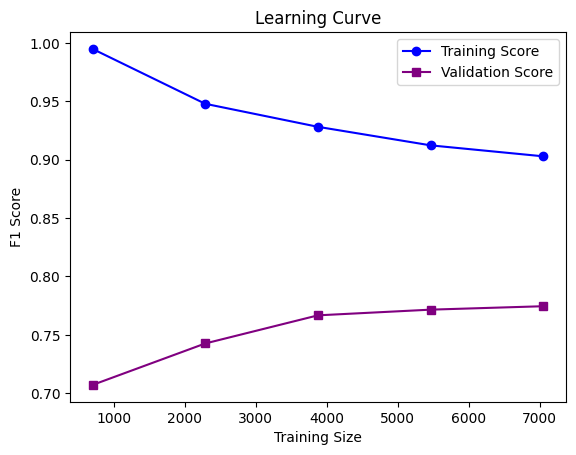

In [43]:
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', color='blue', label='Training Score')
plt.plot(train_sizes, val_scores.mean(axis=1), marker='s', color='purple', label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

The customized logistic regression with softmax is successfully converging, as evidenced by the steady decrease in both training cross-entropy loss and validation cross-entropy loss across epochs. This demonstrates excellent generalization with no signs of overfitting.

In [44]:
y_pred = grid_search.best_estimator_.predict(X_test)

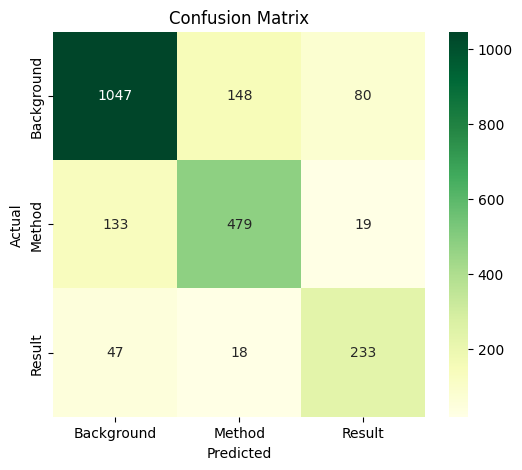

In [45]:
#EVALUATE the model performance through confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)
class_names = ['Background','Method','Result']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

According to the confusion matrix, the highest correct prediction made was for **Background** class with **1047** followed by **479** for **Method** class and **233** for **Results**.
Out of all, the model fasely classified **148** actual Background as Methods which suggests the model has a hard time distinguishing between background information and methodology.

In [46]:
#EVALUATE the model performance through classification report
print(classification_report(y_test_enc, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1275
           1       0.74      0.76      0.75       631
           2       0.70      0.78      0.74       298

    accuracy                           0.80      2204
   macro avg       0.77      0.79      0.78      2204
weighted avg       0.80      0.80      0.80      2204



The model achieved 80% accuracy overall

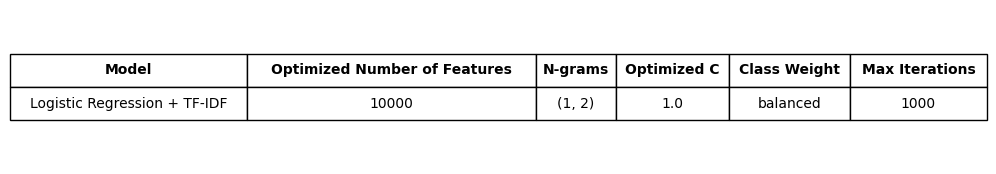

In [47]:
import matplotlib.pyplot as plt

# Extract pipeline steps
tfidf = grid_search.best_estimator_.named_steps['tfidf']
clf = grid_search.best_estimator_.named_steps['clf']

# Prepare configuration table data
table_data = [[
    'Logistic Regression + TF-IDF',
    tfidf.max_features,
    tfidf.ngram_range,
    clf.C,
    clf.class_weight,
    clf.max_iter
]]

columns = [
    'Model',
    'Optimized Number of Features',
    'N-grams',
    'Optimized C',
    'Class Weight',
    'Max Iterations'
]

fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')

table = ax.table(cellText=table_data, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

for col in range(len(columns)):
    table[0, col].get_text().set_weight('bold')

table.scale(1, 2)
table.auto_set_column_width(range(len(columns)))

plt.show()

#####**2. SciBERT**


In [48]:
#DEFINE the model in use
scibert_model = "allenai/scibert_scivocab_uncased"
num_labels = 3

In [49]:
#LOAD tokenizer
tokenizer = AutoTokenizer.from_pretrained(scibert_model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [60]:
#scibert = TFAutoModelForSequenceClassification.from_pretrained(scibert_model, num_labels=num_labels, from_pt=True)
scibert = TFAutoModelForSequenceClassification.from_pretrained(scibert_model, num_labels=num_labels, from_pt=True, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
X_tr_text, X_val_text, y_tr_enc, y_val_enc = train_test_split(X_train, y_train_enc, test_size=0.2, stratify=y_train_enc, random_state=42)

In [62]:
train_encodings = tokenizer(list(X_tr_text), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val_text), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [63]:
batch_size=8
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_tr_enc
)).shuffle(1000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val_enc
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_enc
)).batch(batch_size)

In [64]:
train_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [65]:
scibert.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

#scibert.optimizer.learning_rate.assign(2e-5)
scibert.optimizer.learning_rate.assign(5e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=4.999999873689376e-05>

In [56]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [66]:
history = scibert.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    class_weight=class_weights_dict,
)

Epoch 1/3
882/882 [==============================] - 289s 260ms/step - loss: 0.5825 - accuracy: 0.7772 - val_loss: 0.4886 - val_accuracy: 0.7971
Epoch 2/3
882/882 [==============================] - 217s 246ms/step - loss: 0.4808 - accuracy: 0.8331 - val_loss: 0.4849 - val_accuracy: 0.8158
Epoch 3/3
882/882 [==============================] - 217s 246ms/step - loss: 0.3972 - accuracy: 0.8636 - val_loss: 0.5224 - val_accuracy: 0.8192


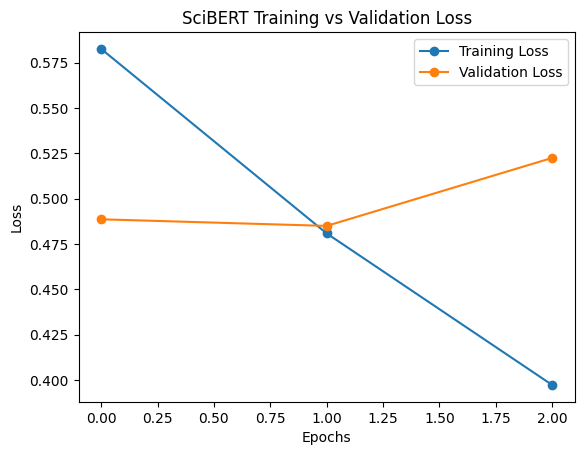

In [67]:
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SciBERT Training vs Validation Loss')
plt.legend()
plt.show()

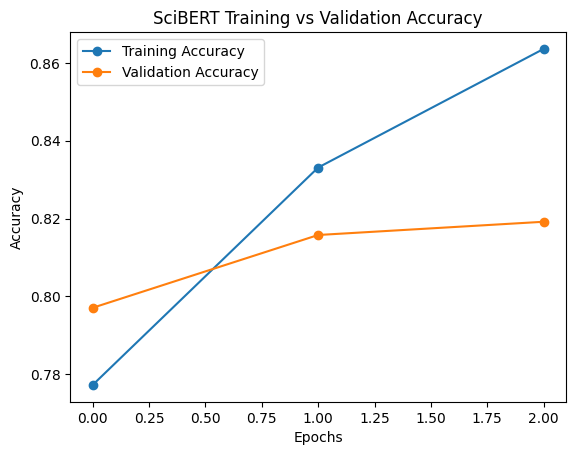

In [68]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SciBERT Training vs Validation Accuracy')
plt.legend()
plt.show()

The training loss keeps decreasing and training accuracy keeps increasing, while validation loss increases and validation accuracy stagnates. This divergence indicates the model is overfitting to the training data.

In [69]:
test_loss, test_acc = scibert.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

276/276 [==============================] - 23s 84ms/step - loss: 0.5307 - accuracy: 0.8103
Test Loss: 0.5307, Test Accuracy: 0.8103


In [70]:
predictions = scibert.predict(test_dataset)
logits = predictions.logits
pred_labels = tf.argmax(logits, axis=1).numpy()

276/276 [==============================] - 26s 84ms/step


In [71]:
print(classification_report(y_test_enc, pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1275
           1       0.75      0.78      0.77       631
           2       0.69      0.82      0.75       298

    accuracy                           0.81      2204
   macro avg       0.77      0.81      0.79      2204
weighted avg       0.82      0.81      0.81      2204



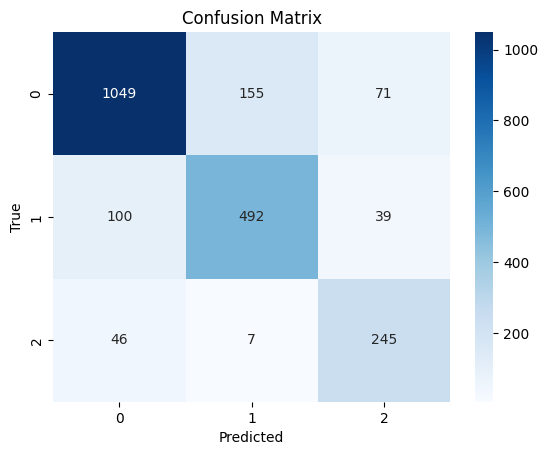

In [72]:
cm = confusion_matrix(y_test_enc, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
with open("traditional_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [ ]:
from google.colab import files
files.download("traditional_model.pkl")